# Included in this Notebook

1. Importing libraries and data
2. Subsetting, wrangling, and cleaning time-series data
3. Time series analysis: decomposition
4. Testing for stationarity
5. Stationarizing the Federal Reserve Economic Data

## Importing Libraries and Data

In [1]:
# Importing Libraries
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings 

warnings.filterwarnings("ignore") 

plt.style.use('fivethirtyeight') 

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'jz-q3vEQxaaxcvn3sr9_'

In [22]:
# Importing the IMF Cross Country Macroeconmic Statistics.

data = quandl.get('ODA/GBR_NGDPRPPPPC')

In [23]:
# Checking the dataset
data.head()

,Value
Date,
1980-12-31,20547.12
1981-12-31,20378.55
1982-12-31,20812.97
1983-12-31,21682.03
1984-12-31,22139.02


In [28]:
data.tail()

,Value
Date,
2020-12-31,41192.20
2021-12-31,41606.29
2022-12-31,42044.02
2023-12-31,42513.42
2024-12-31,42997.95


In [24]:
data.shape

(45, 1)

In [25]:
data.columns

Index(['Value'], dtype='object')

In [26]:
type(data)

pandas.core.frame.DataFrame

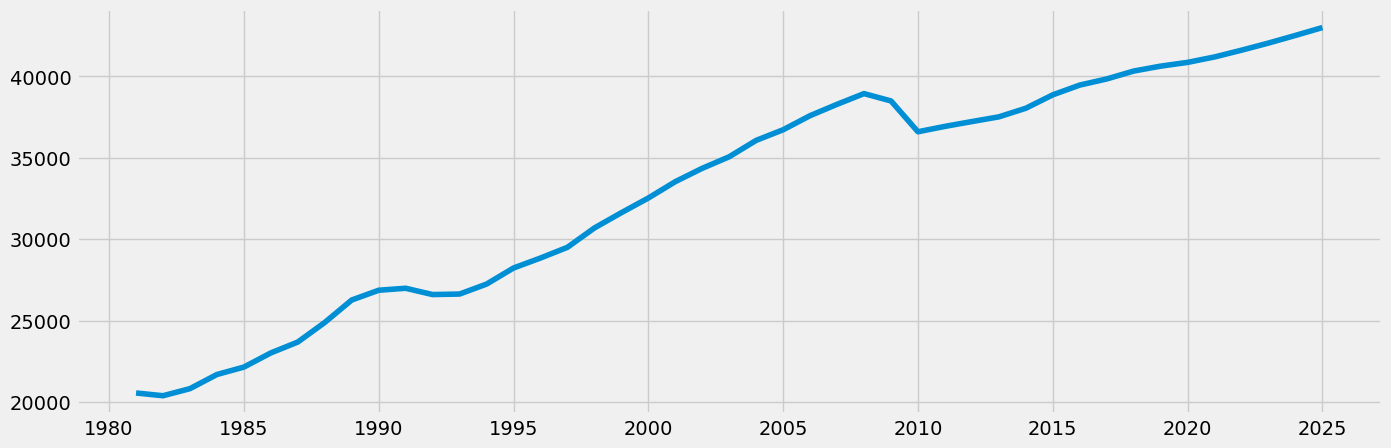

In [27]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100)

plt.plot(data)

## Subsetting, Cleaning and Wrangling for time series data

In [29]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [30]:
data_2.head()

,Date,Value
0,1980-12-31,20547.12
1,1981-12-31,20378.55
2,1982-12-31,20812.97
3,1983-12-31,21682.03
4,1984-12-31,22139.02


In [31]:
# Creating a subset of the data
data_sub = data_2.loc[(data_2['Date'] >= '2015-01-01') & (data_2['Date'] < '2023-01-01')]

I selected this subset because in my original project data we are only looking at the years between 2015 through 2019. I also wanted to look at the data from the past three years as well. So I excluded years before 2015 and years that are forecast (as well as this year as it is not concluded yet).

In [32]:
data_sub.shape

(8, 2)

In [33]:
data_sub.head()

,Date,Value
35,2015-12-31,39462.62
36,2016-12-31,39839.53
37,2017-12-31,40324.98
38,2018-12-31,40626.72
39,2019-12-31,40857.83


In [34]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date'])
data_sub = data_sub.set_index('datetime') 
data_sub.drop(['Date'], axis=1, inplace=True) 
data_sub.head()

,Value
datetime,
2015-12-31,39462.62
2016-12-31,39839.53
2017-12-31,40324.98
2018-12-31,40626.72
2019-12-31,40857.83


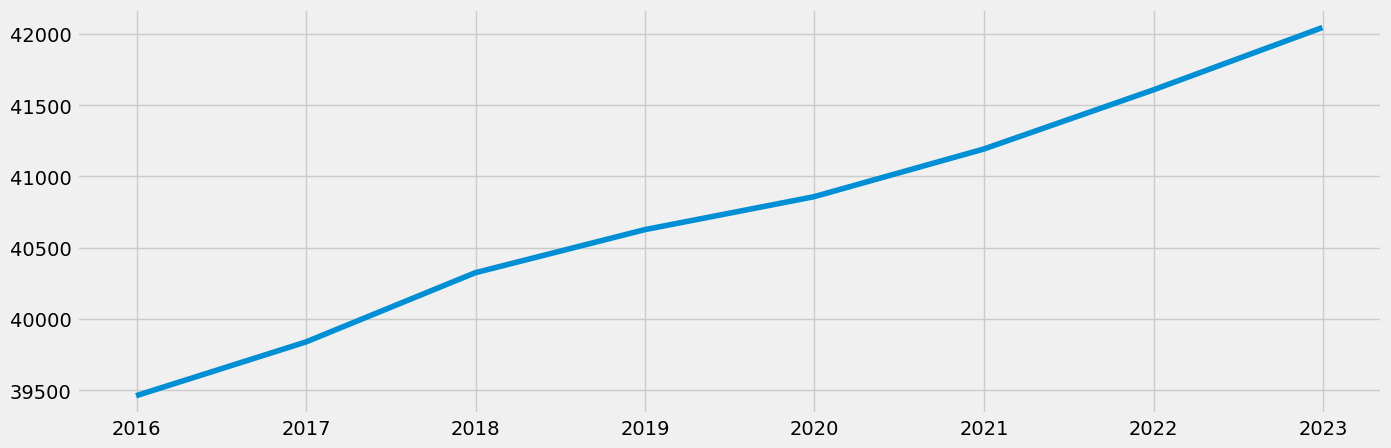

In [35]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [37]:
# Check for missing values 

data_sub.isnull().sum() 

Value    0
dtype: int64

In [38]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

0

## Time Series Analysis: Decomposition

In [39]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [40]:
from pylab import rcParams 

rcParams['figure.figsize'] = 18, 7

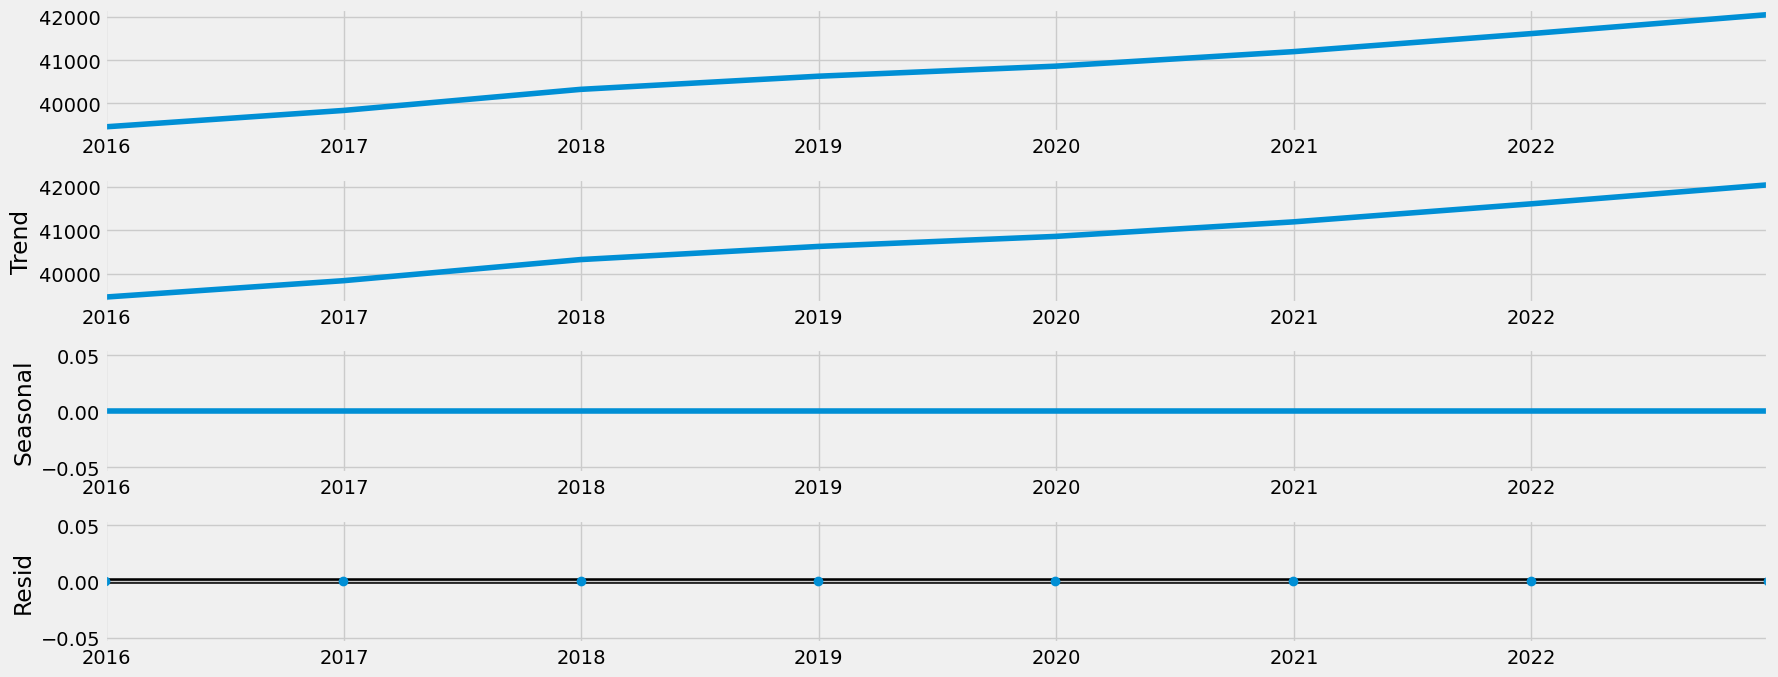

In [41]:
# Plot the separate components

decomposition.plot()
plt.show()

The results of the decomposition show us that there is an upword trend in the data. However there is no seasonality, or noise in the data.

## Testing for stationarity

In [42]:
from statsmodels.tsa.stattools import adfuller 

def dickey_fuller(timeseries): 
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)


dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                 8.157110
p-value                        1.000000
Number of Lags Used            2.000000
Number of Observations Used    5.000000
Critical Value (1%)           -6.045114
Critical Value (5%)           -3.929280
Critical Value (10%)          -2.986810
dtype: float64


When looking at the statistics it is clear we cannot reject our null hypothesis. This is because our p-value is greater than 0.05. And our test statistic of 8.157 is greater than all three of our critical values. In order to reject our null hypothesis and prove that the data is stationart we need the test statistic to be less than our critical values.

## Stationarizing the Data

In [43]:
data_diff = data_sub - data_sub.shift(1) 

In [44]:
# Dropping missing values
data_diff.dropna(inplace = True) 

In [45]:
data_diff.head()

,Value
datetime,
2016-12-31,376.91
2017-12-31,485.45
2018-12-31,301.74
2019-12-31,231.11
2020-12-31,334.37


In [46]:
data_diff.columns

Index(['Value'], dtype='object')

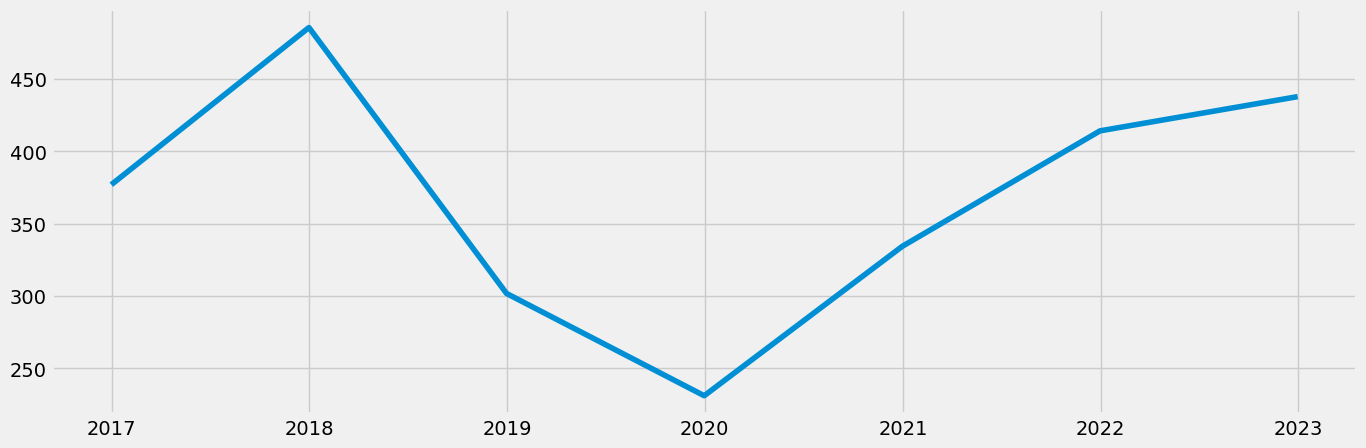

In [47]:
# Plot the time-series

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [48]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -3.488579
p-value                        0.008285
Number of Lags Used            1.000000
Number of Observations Used    5.000000
Critical Value (1%)           -6.045114
Critical Value (5%)           -3.929280
Critical Value (10%)          -2.986810
dtype: float64


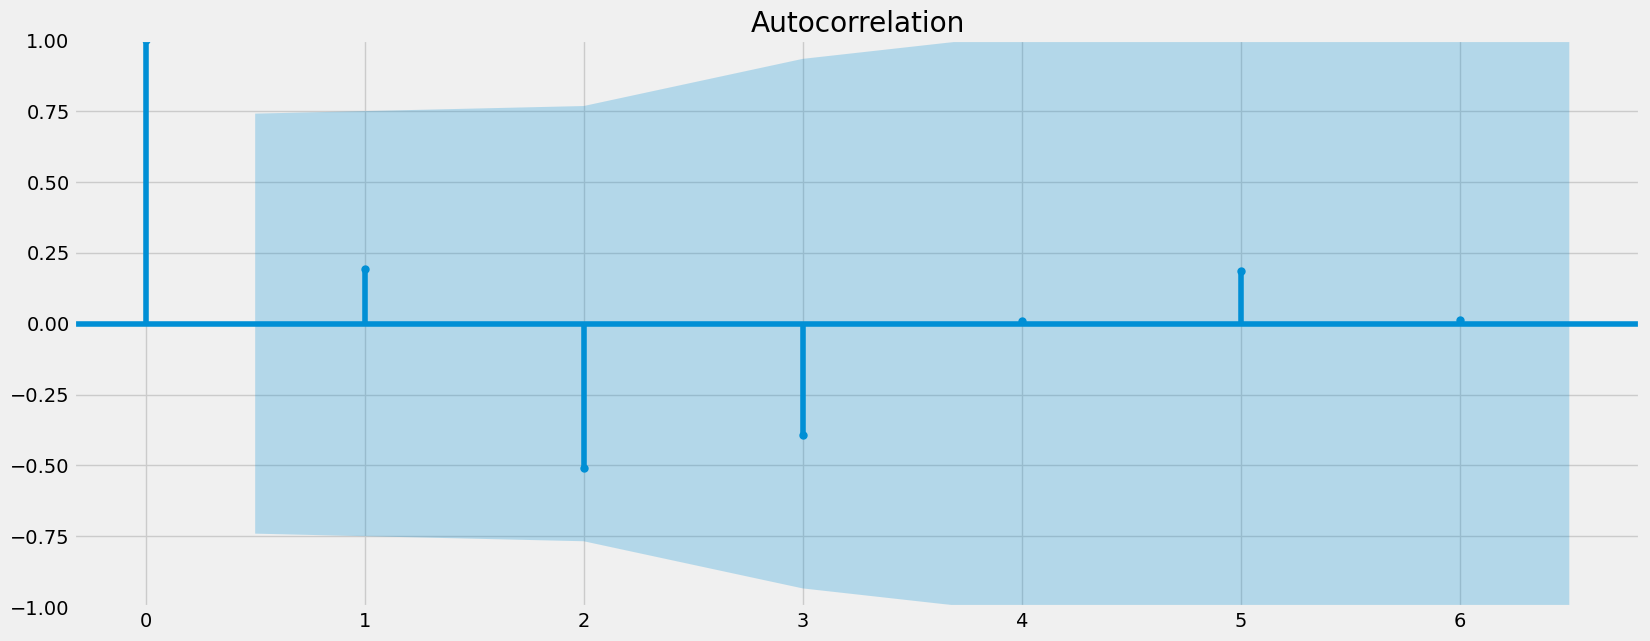

In [50]:
# Checking Autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
plot_acf(data_diff)
plt.show()